In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import output_functions as of
import testdata_proc as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf
import testdata_proc as pf
import plotly.graph_objects as go
import plotly.io as pio
import os

In [21]:
run = 17
branch = 211
ca = 'BAU'
site_capacity = {
        'BAU': 10000}
range_profile = pickle.load(open(
    'Outputs/LogsJLP/run{}/range_profiles'.format(run), 'rb'))
days_summary = pickle.load(open(
    'Outputs/LogsJLP/run{}/days_summary'.format(run), 'rb'))
empty_profs = pickle.load(open(
    'Outputs/LogsJLP/empty_profiles'.format(run), 'rb'))

veh_agg = range_profile.groupby(['date','Vehicle_ID']).sum()
veh_agg.loc[dt.datetime(2020,8,8)]
day_profile2 = range_profile.loc[
    dt.datetime(2020,8,8,10,0,0):dt.datetime(2020,8,9,10,30,0)]
empty_profile = empty_profs[branch]

In [22]:
jour = pickle.load(
    open(os.path.join(gv.LOGS, r'all_journeys'), 'rb'))
journeys = pd.concat(jour)
journeys['Start_Time'] = journeys['Start_Time_of_Route'].dt.time
journeys['End_Time'] = journeys['End_Time_of_Route'].dt.time
days_summary[days_summary['Level_BAU']=='Magic']

In [24]:
# Single day optimisation on 7/8 to see what's going on.
charger = gv.STORE_SPEC[branch]['CH']
req_energy = empty_profile.groupby(
    ['date','Vehicle_ID']).sum()[['Battery_Use']]*(
        1+gv.MARGIN_SOC)
nVeh = len(empty_profile.index.get_level_values(
        'Vehicle_ID').unique())
battery_cap = gv.VSPEC[gv.STORE_SPEC[branch]['V']]['C']
last_day = req_energy.index[-1][0]+dt.timedelta(days=1)
for v in empty_profile.index.get_level_values('Vehicle_ID').unique():
    req_energy.loc[(last_day,v),'Battery_Use'] = 0
req_energy['Full_Use'] = -battery_cap
req_energy['Req_Battery'] = req_energy[['Battery_Use','Full_Use']].max(axis=1)
day = dt.datetime(2020,9,7)
day_profile = pf.create_daily_schedule(empty_profile, day)
next_req = req_energy.loc[(day+dt.timedelta(days=1),slice(None)),'Req_Battery'].droplevel(level=0)
initial_rel_charge = pd.Series(
        data = [0]*nVeh,
        index = empty_profile.index.get_level_values(1).unique()
    )
output_df, PuLP_prob, fsoc, _, opt_level = lpf.linear_optimiser_V4(
                    day_profile,
                    ca,
                    charger[0], charger[1],
                    10000,
                    initial_rel_charge,
                    next_req, battery_cap
                    )

day_profile_out = day_profile.merge(
                output_df,
                how='left',
                left_index=True,
                right_index=True,
                )
range_profile = day_profile_out.fillna(0)
cols = gv.CAT_COLS
vehicles = output_df.index.get_level_values(1).unique()

range_profile[cols['CHARGE_DEL'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * gv.CHARGER_EFF)
range_profile[cols['ECOST'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * range_profile[cols['PRICE']['opt']])
for vehicle in vehicles:
    range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
        battery_cap + initial_rel_charge
        + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
        + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
        )*100/battery_cap


BAU status: Infeasible
BAU Next required charge status: Optimal
Cost: -17326.4035303707


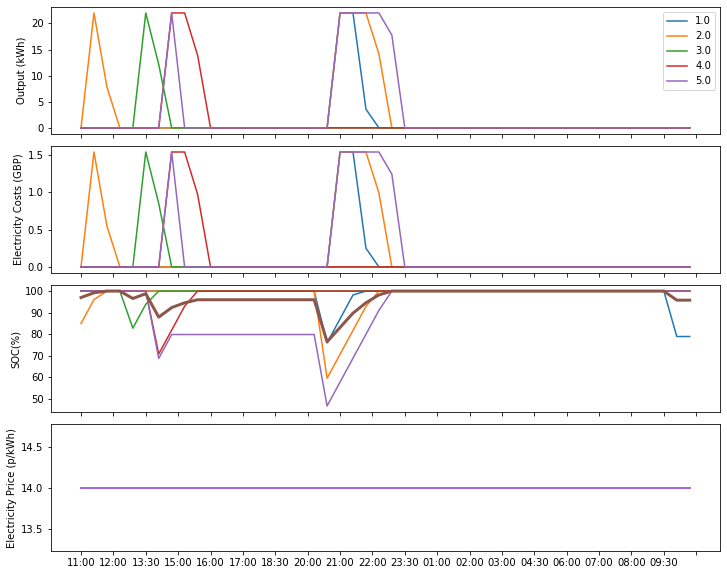

In [25]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='BAU'
x = range_profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    range_profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(range_profile.unstack()[cols['OUTPUT'][ca]].columns)
# axs[0].plot(
#     x,
#     range_profile[cols['OUTPUT'][ca]].groupby('from').sum()*2, linewidth=3)
axs[0].set_ylabel('Output (kWh)')

axs[1].plot(
    x, 
    range_profile.unstack()[cols['ECOST'][ca]]/100)
# axs[1].plot(
#     x,
#     range_profile[cols['ECOST'][ca]].groupby('from').sum()/100, linewidth=3)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    range_profile.unstack()[cols['SOC'][ca]])
axs[2].plot(
    x,
    range_profile[cols['SOC'][ca]].groupby('from').mean(), linewidth=3)
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    range_profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()